# Predicting Morris Wind Energy

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

%matplotlib inline
sns.set(rc = {"figure.figsize" : (10, 8)})

## Reading the Dataset

In [2]:
# Making my own column names
column_names = ['TimeStamp', 'min_production', 'avg_production', 'max_production', 'min_wind_speed', 'avg_wind_speed', 'max_wind_speed', 'min_temp', 'avg_temp', 'max_temp', 'overall_production', 'GridTime']
# Need to remove the first 6 lines since they they are only the column titles in the google sheet
data = pd.read_csv("./MorrisDataNoNA.csv", names = column_names, skiprows = 6)
data.head()

,TimeStamp,min_production,avg_production,max_production,min_wind_speed,avg_wind_speed,max_wind_speed,min_temp,avg_temp,max_temp,overall_production,GridTime
0,31/12-2008 23:00:00,"1,658","1,668","1,679",11,12.8,15,-10,-10,-9,"1,677",1
1,31/12-2008 22:00:00,"1,659","1,669","1,676",12,12.8,14,-11,-11,-10,"1,680",1
2,31/12-2008 21:00:00,"1,660","1,668","1,675",11,12.4,13,-11,-11,-11,"1,673",1
3,31/12-2008 20:00:00,"1,549","1,663","1,687",10,11.5,12,-12,-12,-11,"1,671",1
4,31/12-2008 19:00:00,"1,573","1,662","1,694",10,12.7,15,-13,-12,-12,"1,671",1


## Data Mining

In [3]:
# Need to make all variables (not TimeStamp) float64
columns_to_convert = ['min_production', 'avg_production', 'max_production', 'overall_production', 'min_wind_speed', 'max_wind_speed', 'min_temp', 'avg_temp', 'max_temp', 'GridTime']
for col in columns_to_convert:
        data[col] = data[col].astype(str).str.replace(',', '').astype('float64')
def parse_dates(date_str):
    for fmt in ('%d/%m-%Y %H:%M:%S', '%d/%m/%y %H:%M'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT
data['TimeStamp'] = data['TimeStamp'].apply(parse_dates)
#data = data.set_index('TimeStamp')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TimeStamp           8609 non-null   datetime64[ns]
 1   min_production      8609 non-null   float64       
 2   avg_production      8609 non-null   float64       
 3   max_production      8609 non-null   float64       
 4   min_wind_speed      8609 non-null   float64       
 5   avg_wind_speed      8609 non-null   float64       
 6   max_wind_speed      8609 non-null   float64       
 7   min_temp            8609 non-null   float64       
 8   avg_temp            8609 non-null   float64       
 9   max_temp            8609 non-null   float64       
 10  overall_production  8609 non-null   float64       
 11  GridTime            8609 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 807.2 KB


In [4]:
# Checking for nulls
data.isnull().sum()

TimeStamp             0
min_production        0
avg_production        0
max_production        0
min_wind_speed        0
avg_wind_speed        0
max_wind_speed        0
min_temp              0
avg_temp              0
max_temp              0
overall_production    0
GridTime              0
dtype: int64

## Plotting Data

In [5]:
#sns.pairplot(data)

In [6]:
data1 = data.drop(columns=['TimeStamp'])
df = data1.copy()
print(df.dtypes)
print(df.shape)

#df_numeric = df.apply(pd.to_numeric, errors='coerce') # Check for any NaN values that indicate non-numeric entries 
#print(df_numeric.dtypes)
#df_numeric.info()

min_production        float64
avg_production        float64
max_production        float64
min_wind_speed        float64
avg_wind_speed        float64
max_wind_speed        float64
min_temp              float64
avg_temp              float64
max_temp              float64
overall_production    float64
GridTime              float64
dtype: object
(8609, 11)


# Building the LSTM Model

In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import InputLayer
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

2024-12-04 11:31:07.491739: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 11:31:07.499137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 11:31:07.514852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733333467.536854  640850 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733333467.543738  640850 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 11:31:07.586553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [8]:
df = df.set_index('avg_wind_speed')

In [9]:
# Hardcoding Variables
batch_size_exp = 1
epoch_exp = 15
neurons_exp = 10
predict_values_exp = 500
lag_exp=24

In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [12]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [13]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [14]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [15]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, X.shape[1], X.shape[2])))
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        #model.reset_states()
    return model
    print(model.summary)

In [16]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [17]:
'''Drop all the features as we will not be using in the prediction'''
del df['min_production']
del df['max_production']
del df['min_wind_speed']
del df['max_wind_speed']
del df['min_temp']
del df['max_temp']
del df['avg_production']
del df['avg_temp']
del df['GridTime']
df.head()

,overall_production
avg_wind_speed,
12.8,1677.0
12.8,1680.0
12.4,1673.0
11.5,1671.0
12.7,1671.0


In [18]:
for i in range(0,10):
  df = df.iloc[:-1]
df.tail()

,overall_production
avg_wind_speed,
14.6,1672.0
13.2,1646.0
13.9,1665.0
13.8,1666.0
12.7,1629.0


In [19]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)
print(diff_values.dtype)

object


In [20]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [21]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [22]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [23]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

2024-12-04 11:31:18.346027: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


8098/8098 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0121
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0107
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0106
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0106
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.0105
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0104
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0104
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0104
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0103
8098/8098 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0103


In [24]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Hour=1, Predicted=1332.821134, Expected=933.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Hour=2, Predicted=841.408993, Expected=1332.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Hour=3, Predicted=1261.995804, Expected=1640.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Hour=4, Predicted=1539.015401, Expected=1119.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Hour=5, Predicted=1115.383086, Expected=759.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Hour=6, Predicted=719.764229, Expected=864.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Hour=7, Predicted=836.352853, Expected=678.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Hour=8, Predicted=675.429030, Expected=400.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Hour=9, Predicted=375.025173, Expected=34.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Hour=10, Predicted=0.863783, Expected=36.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hour=11, Predicted=26.912561, Expected=303.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [25]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (1, 10)                │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,235 (16.55 KB)

 Trainable params: 1,411 (5.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,824 (11.04 KB)

In [26]:
# Calculate mean absolute error
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  0.8806289815188226


# Final Prediction Plot

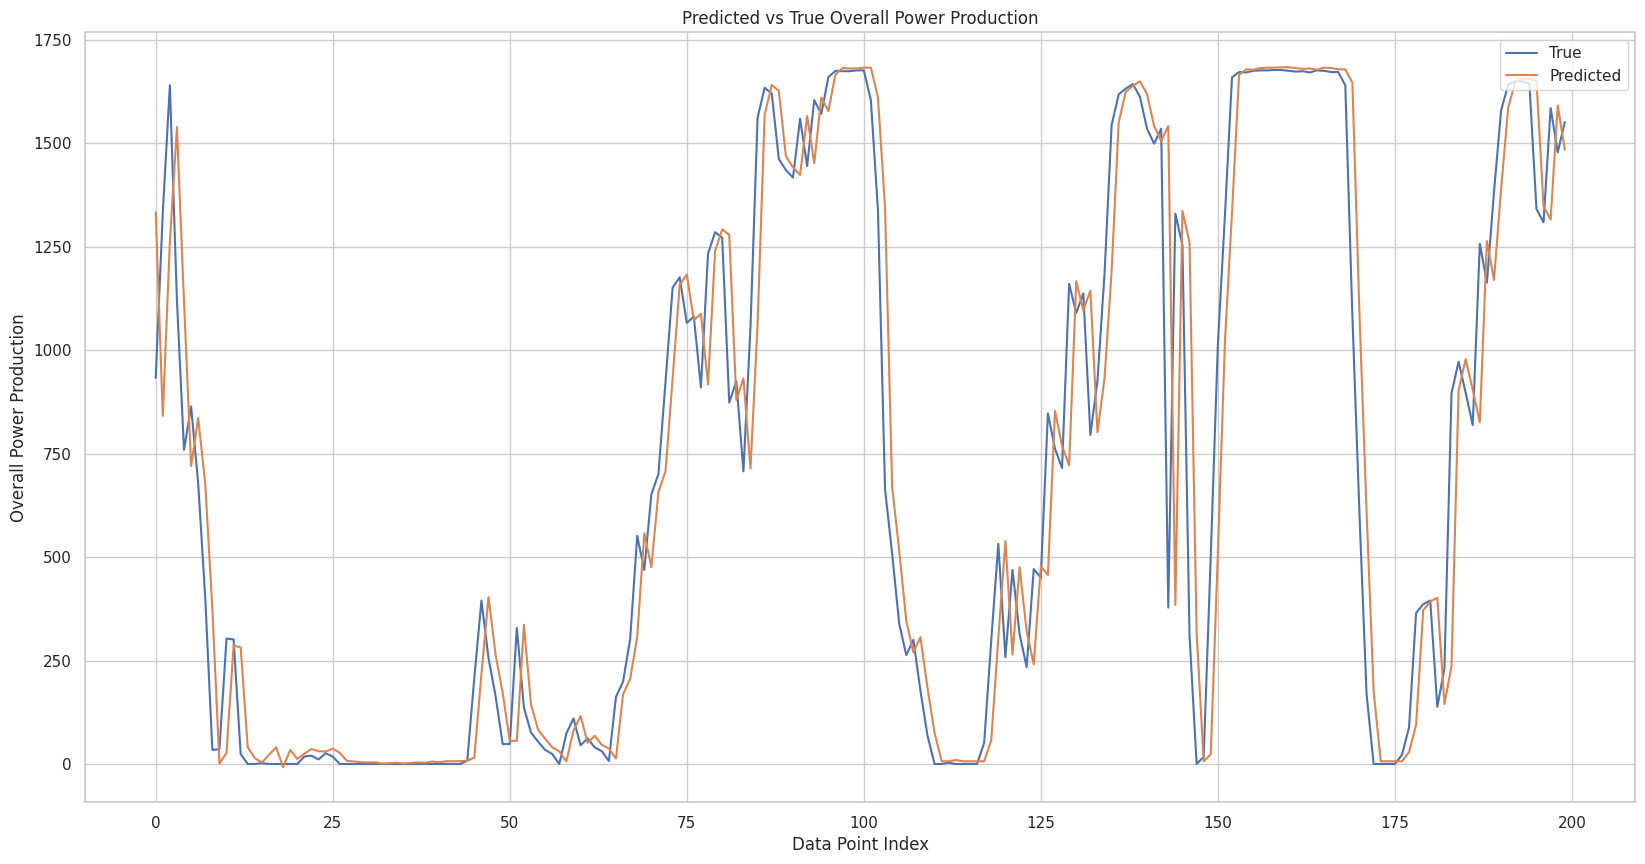

In [27]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:200], label="True")
pyplot.plot(predictions_plot[0:200], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Data Point Index")
pyplot.ylabel("Overall Power Production")
plt.title("Predicted vs True Overall Power Production")
pyplot.show()

This plot compares the true and predicted values of overall power production based on average wind speed. The x-axis represents the data point index, which is the sequence of data points in the dataset, while the y-axis represents the overall power production.

The model is doing a good job at capturing trends in the data and it peaks where it should. The model also seems to be learning the relationship between average wind speed and overall poer production effectivly.  

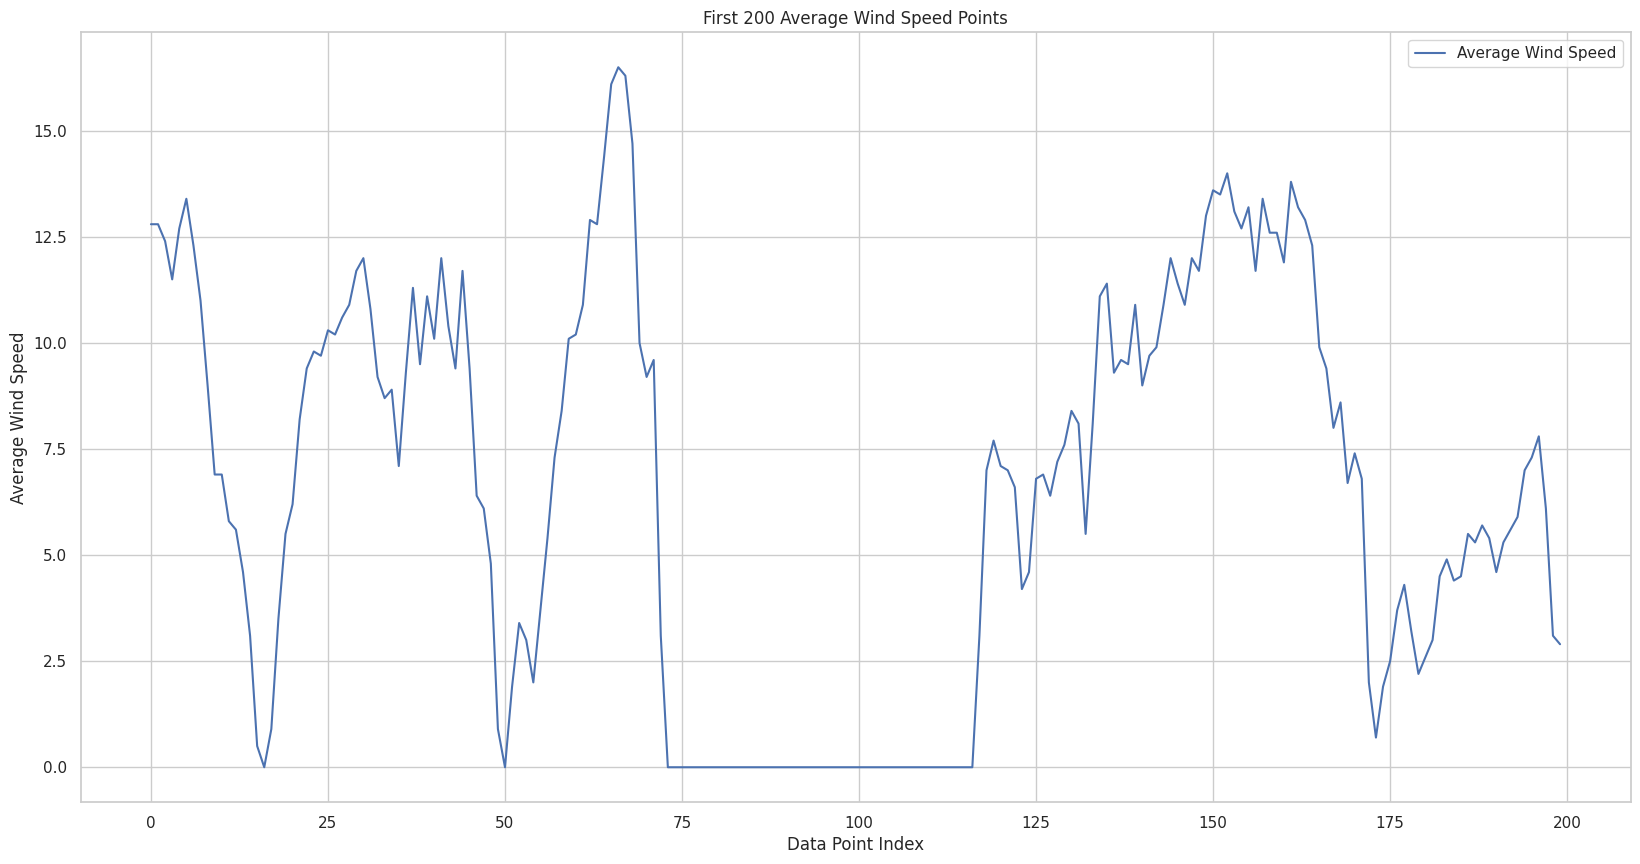

In [28]:
# Assuming 'avg_wind_speed' is in your DataFrame 'df'
avg_wind_speed = df.index.values

# Plotting the first 200 average wind speed points
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.plot(avg_wind_speed[:200], label="Average Wind Speed")
plt.legend(loc='upper right')
plt.xlabel("Data Point Index")
plt.ylabel("Average Wind Speed")
plt.title("First 200 Average Wind Speed Points")
plt.show()

Notice there is no wind from around 75 to 115 but the turbines still produced power. This is likley due to residual power from things like residual motion, grid power, and maintenance. 

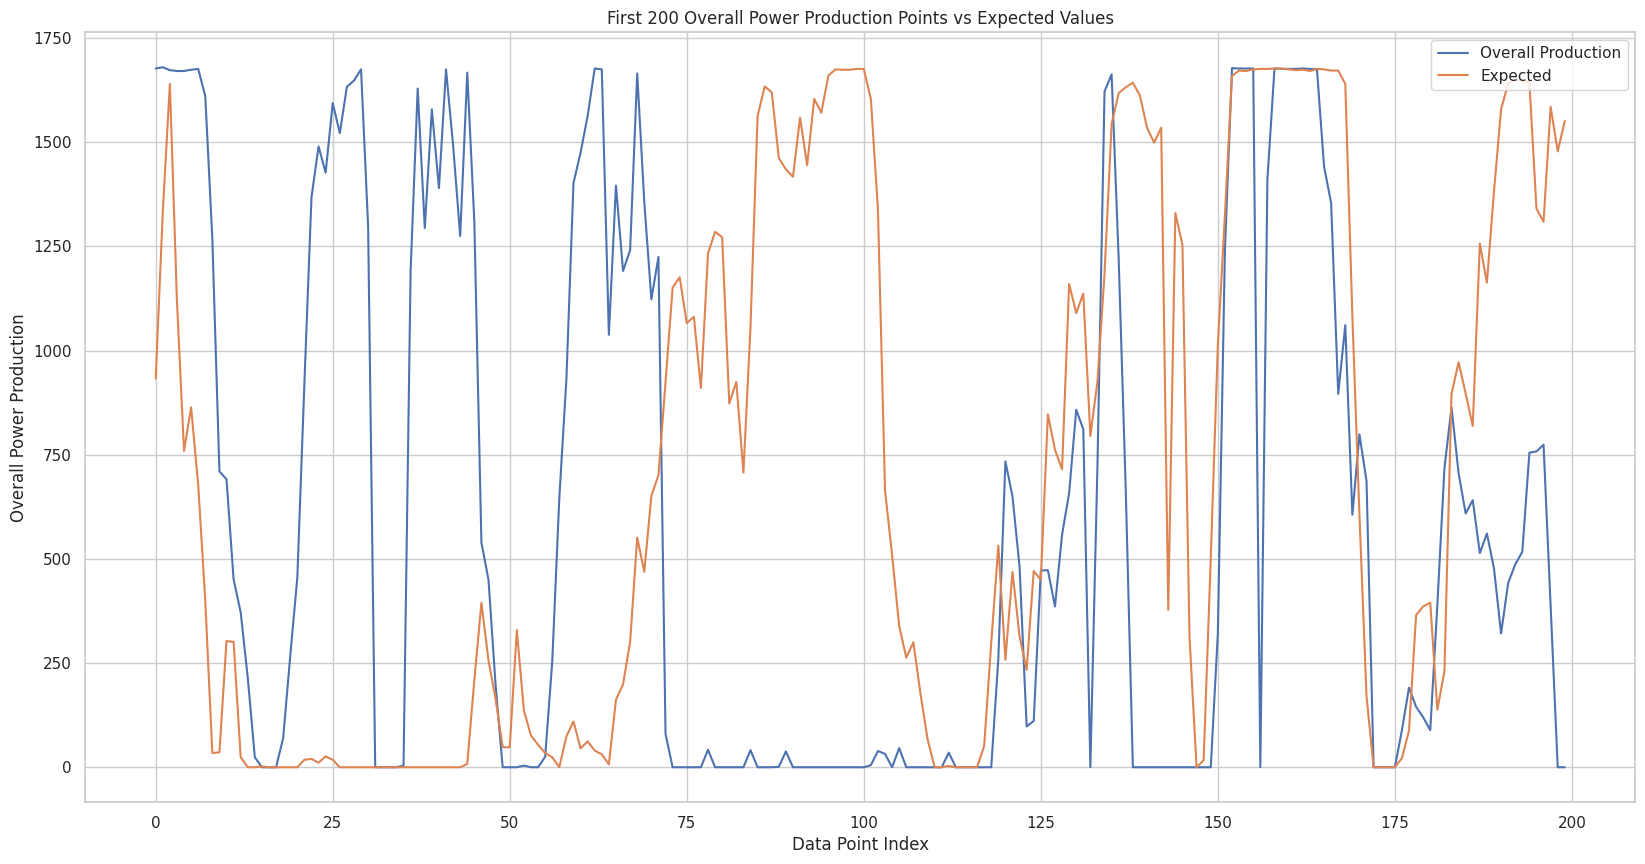

In [29]:
# Assuming 'overall_production' is in your DataFrame 'df'
overall_production = df['overall_production'].values

# Plotting the first 200 overall production points vs expected values
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.plot(overall_production[:200], label="Overall Production")
plt.plot(expectations_plot[:200], label="Expected")
plt.legend(loc='upper right')
plt.xlabel("Data Point Index")
plt.ylabel("Overall Power Production")
plt.title("First 200 Overall Power Production Points vs Expected Values")
plt.show()

